In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import seaborn as sns
import quantstats as qs

In [39]:
vhsi_data = pd.read_csv('HSI_VHSI, 1D_a0956.csv')
hsi_data = pd.read_csv('TVC_HSI, 1D_49f32.csv')

In [40]:
vhsi_data.set_index('time', inplace=True)
vhsi_data.index = [time.replace('T09:20:00+08:00', '') for time in vhsi_data.index]

hsi_data.set_index('time', inplace=True)
hsi_data.index = [time.replace('T09:20:00+08:00', '') for time in hsi_data.index]

In [41]:
rolling_window = 60
hsi_data['return'] = hsi_data['close'].pct_change()
hsi_data['HV'] = hsi_data['return'].rolling(window=rolling_window).std() * (365**0.5)

In [42]:
backtest_period = ['2008-01-01', '2020-12-31']
ftest_period = ['2022-09-25', '2023-06-12']

HV_backtest_data = hsi_data.loc[backtest_period[0]:backtest_period[1]]['HV']
IV_backtest_data = vhsi_data.loc[backtest_period[0]:backtest_period[1]]['close'] * 0.01

In [43]:
def BB(data, rolling_window, std_multiplier):
    SMA = data.rolling(window=rolling_window).mean()
    std = data.rolling(window=rolling_window).std()
    lower_bound = SMA - std_multiplier*std
    upper_bound = SMA + std_multiplier*std
    
    return SMA, lower_bound, upper_bound

In [44]:
def VRP_BB_bound(df):
    
    df.index = pd.to_datetime(df.index, utc=True)
    open_date = []
    close_date = []
    open_position = False
    open_price = []
    close_price = []

    for date, row in df.iterrows():
        
        last_index_condtion = date == df.index[-1]
        
        if row['VRP'] <= row['lower_band'] and not open_position:
            open_date.append(date)
            open_price.append(row['close'])
            open_position = True

        if (row['VRP'] >= row['middle_band'] or last_index_condtion) and open_position == True:
            close_date.append(date)
            close_price.append(row['close'])
            open_position = False
            
    open_price = np.array(open_price)
    close_price = np.array(close_price)
    open_date = np.array(open_date)
    close_date = np.array(close_date)
    
    profit = open_price - close_price 
    abs_profit = abs(profit)
    freq = len(profit)
    holding = close_date - open_date

    if freq != 0:   
        winning_rate = len(profit[profit > 0]) / freq
        holding_median = np.median(holding).days
        profit_median = np.median(abs_profit)
        
    else: 
        winning_rate = np.nan
        holding_median = np.nan
        profit_median = np.nan
        
    return winning_rate, freq, holding_median, profit_median

In [47]:
# Tuning parameters
rolling_window_list = list(range(1,16))
std_multiplier_list = np.array(list(range(50, 325, 25)))/100
winning_rate_list = []

VRP = IV_backtest_data-HV_backtest_data
VRP = VRP.rename('VRP')

result_dict = {}
result_dict['rolling_window'] = []
result_dict['std_multiplier'] = []
result_dict['winning_rate'] = []
result_dict['Freq'] = []
result_dict['median_holding_period'] = []
result_dict['volatility_median'] = []

for rolling_window in rolling_window_list:
    for std_multiplier in std_multiplier_list:
        
        middle_band, lower_band, upper_band = BB(VRP, rolling_window, std_multiplier)

        lower_band = lower_band.rename('lower_band')
        upper_band = upper_band.rename('upper_band')
        middle_band = middle_band.rename('middle_band')

        HV_backtest_data.index = pd.to_datetime(HV_backtest_data.index)
        HV_backtest_data.index = [time.strftime('%Y-%m-%d') for time in HV_backtest_data.index]

        IV_backtest_data.index = pd.to_datetime(IV_backtest_data.index)
        IV_backtest_data.index = [time.strftime('%Y-%m-%d') for time in IV_backtest_data.index]
        df = pd.concat([HV_backtest_data, IV_backtest_data, middle_band, upper_band, lower_band, VRP], axis=1)
        
        winning_rate, freq, holding_median, volatility_median = VRP_BB_bound(df)
        
        result_dict['rolling_window'].append(rolling_window)
        result_dict['std_multiplier'].append(std_multiplier)
        result_dict['winning_rate'].append(winning_rate)
        result_dict['Freq'].append(freq)
        result_dict['median_holding_period'].append(holding_median)
        result_dict['volatility_median'].append(volatility_median)
            
result_df = pd.DataFrame.from_dict(result_dict)

In [48]:
result_df.sort_values(by='volatility_median', ascending=False)

,rolling_window,std_multiplier,winning_rate,Freq,median_holding_period,volatility_median
153,14,3.00,0.0,1,7.0,0.0311
152,14,2.75,0.0,1,7.0,0.0311
107,10,2.50,0.0,1,4.0,0.0290
130,12,2.75,0.0,1,4.0,0.0290
96,9,2.50,0.0,1,4.0,0.0290
...,...,...,...,...,...,...
98,9,3.00,NaN,0,NaN,NaN
108,10,2.75,NaN,0,NaN,NaN
109,10,3.00,NaN,0,NaN,NaN
120,11,3.00,NaN,0,NaN,NaN


In [53]:
def VRP_BB_bound_sharpe(df):
    
    df.index = pd.to_datetime(df.index)
    open_date = []
    close_date = []
    open_position = False
    open_price = []
    close_price = []

    for date, row in df.iterrows():
        
        last_index_condtion = date == df.index[-1]
        
        if row['VRP'] <= row['lower_band'] and not open_position:
            open_date.append(date)
            open_price.append(row['close'])
            open_position = True

        if (row['VRP'] >= row['middle_band'] or last_index_condtion) and open_position == True:
            close_date.append(date)
            close_price.append(row['close']) 
            open_position = False
            
    open_price = np.array(open_price)
    close_price = np.array(close_price)
    open_date = np.array(open_date)
    close_date = np.array(close_date)
    
    pct_return = pd.DataFrame((close_price - open_price)/open_price)
    sharpe_ratio = qs.stats.sharpe(pct_return, periods=365)
    freq = len(pct_return)

    if freq == 0:
        sharpe_ratio = np.nan
        
    return sharpe_ratio

Text(0.5, 1.0, 'Sharpe_ratio')

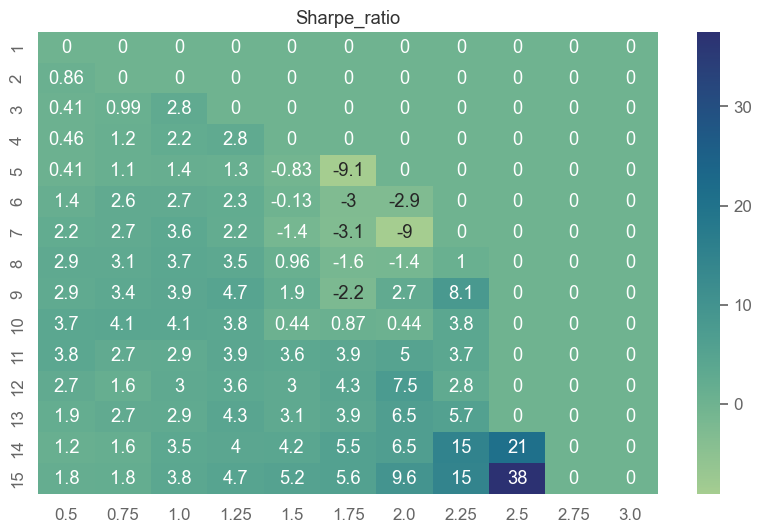

In [54]:
rolling_window_list = list(range(1,16))
std_multiplier_list = np.array(list(range(50, 325, 25)))/100

VRP = IV_backtest_data-HV_backtest_data
VRP = VRP.rename('VRP')

result_dict = {}

for rolling_window in rolling_window_list:
    for std_multiplier in std_multiplier_list:
        
        middle_band, lower_band, upper_band = BB(VRP, rolling_window, std_multiplier)

        lower_band = lower_band.rename('lower_band')
        upper_band = upper_band.rename('upper_band')
        middle_band = middle_band.rename('middle_band')

        HV_backtest_data.index = pd.to_datetime(HV_backtest_data.index)
        HV_backtest_data.index = [time.strftime('%Y-%m-%d') for time in HV_backtest_data.index]
        df = pd.concat([HV_backtest_data, IV_backtest_data, middle_band, upper_band, lower_band, VRP], axis=1)
        
        sharpe_ratio = VRP_BB_bound_sharpe(df)
        
        result_dict.update({(rolling_window, std_multiplier):float(sharpe_ratio)})

ser = pd.Series(list(result_dict.values()), index=pd.MultiIndex.from_tuples(result_dict.keys()))
sharpe  = ser.unstack().fillna(0)
sns.heatmap(sharpe, annot = True, cmap = "crest").set_title('Sharpe_ratio')

In [56]:
result_df[result_df['std_multiplier'] == 1.5]

,rolling_window,std_multiplier,winning_rate,Freq,median_holding_period,volatility_median
4,1,1.5,NaN,0,NaN,NaN
15,2,1.5,NaN,0,NaN,NaN
26,3,1.5,NaN,0,NaN,NaN
37,4,1.5,NaN,0,NaN,NaN
48,5,1.5,0.520000,50,6.0,0.00840
59,6,1.5,0.517241,58,7.0,0.00795
70,7,1.5,0.474576,59,8.0,0.00880
81,8,1.5,0.428571,56,8.0,0.01070
92,9,1.5,0.411765,51,9.0,0.00950
103,10,1.5,0.466667,45,12.0,0.01170
